# Model to predict **Return** when a customer repurchases a product

### Problem Statement
#### Observation:
It has been observed that some customers are re-purchasing a merchandize (which they have purchased some times back with a higher price) with an "intent to return the repurchased merchandize" to get a "price adjustment" against the "merchandize purchased earlier". 

This behavior is causing Macy’s to loose money by incurring return shipping cost, warehouse cost, restocking cost, etc. This adds up to a significant amount at the end of the year.

** We are going to build a model on historical data (containing transactions where repurchase is observed) to predict and return behavior based on Customer profile , Product Attributes and RFM score.** 


In [1]:
#### Libraries

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 14,}

from scipy.stats import mode
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### change path here to point to Raw data

import os
os.chdir("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Ashwini\\lavanya_code_exe")

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Datasets

we have the following datasets 
>* Sales data - transactions
>* Product Attributes
>* Customer Attributes
>* RFM Score and related attributes
>* Customer history of returns


In [2]:
#### Sales data with Product Details Attached 
    #Find the Source SQL from Vaibhav and collate

main_data = pd.read_csv("Macys_Repurchase_Product.csv",encoding='latin-1')
# main_data.head(5)
    
#### Customer Data 

cust_data = pd.read_csv("Customer_data.csv",encoding='latin-1')
# cust_data.head(5)

#### RFM Score Data

RFM_data = pd.read_csv("RFM_score_data.csv")
# RFM_data.head(5)

#### Customer History of returns

cust_ret_data = pd.read_csv("customer_history_returns.csv")

# We have to do some calculations and transformations on the historical data to get the target variable

### In the intrim we are alro derriving a few attributes that adds more defination to the repurchase behavior
### Once repurchase behavior is detected we shall go ahead and predict if the repurchased product is succeptible to return

* prc_chg_dollar
* prc_chg_pct
* time_to_new_purchase
* prc_chg_per_day
* return_duration_from_recent_buy
* return_status
>* Both Kept
>* Both Returned
>* Returned Old
>* Returned New

In [3]:
main_data.columns

Index(['cid', 'upc', 'oid', 'dt', 'r_dt', 'prc', 'qty', 'amt', 'r_qty',
       'r_amt', 'web_prod_id', 'PROD_DESC', 'PROD_TYP_DESC', 'BRND_NM',
       'VND_NM', 'GMM_DESC', 'PARENT_MDSE_DIVN_DESC', 'BUYER_DESC',
       'MDSE_DEPT_DESC', 'LBL_NM'],
      dtype='object')

In [4]:
cust_data.columns

Index(['cid', 'LST_NM', 'MDDL_INIT_NM', 'MDDL_NM', 'FRST_NM', 'TTL_CD',
       'TTL_DESC', 'DOB_DT', 'BIRTH_MNTH_CD', 'GNDR_CD', 'EMP_CD', 'EMP_IND',
       'FED_EMP_IND', 'ALT_LANG_CD', 'ACCT_ADDR_RECD_TYP_CD', 'ADDR_LN_1_TXT',
       'ADDR_LN_2_TXT', 'CITY_NM', 'STT_CD', 'PROV_CD', 'ZIP_CD', 'ZIP4_CD',
       'CNTRY_CD', 'ADDR_UPD_NCOA_TS', 'ADDR_UPD_TS', 'MBL_PHN_IND',
       'OUTLET_SMS_IND', 'BEST_PHN_NBR', 'BEST_PHN_SRC_PHN_NBR',
       'BEST_PHN_TYP_CD', 'BEST_EMAIL_ADDR_TXT',
       'BEST_EMAIL_SRC_EMAIL_ADDR_TXT', 'SMS_IND', 'CARR_RTE_CD', 'CBSA_CD',
       'CMPND_GRP_CD', 'CNSS_BLOCK_GRP_CD', 'CNSS_MIN_CVL_DIVN_CD',
       'CNSS_PLACE_CD', 'CNSS_TRACT_CD', 'CNSS_TRACT_TXT', 'CUST_SEC_IND',
       'DLVR_SEQ_FILE_DLVR_IND_CD', 'DLVR_SEQ_FILE_DLVR_IND_CD_DESC',
       'DLVR_SEQ_FILE_DLVR_TYP_CD', 'DLVR_SEQ_FILE_DLVR_TYP_CD_DESC',
       'DPB_NBR', 'DRCT_MKTNG_ASSOCTN_CD', 'FIPS_CNTY_CD',
       'FIPS_MIN_CVL_DIVN_CD', 'FIPS_PLACE_CD', 'FIPS_STT_CD', 'LAT_NBR',
       'LONG_NBR',

In [3]:
####### we are taking the sales data to be grouped by CID and UPC 
### filtering on this count will only keep the customers who have repurchased a cetain product within this timeframe

count_data = main_data.groupby(['cid','upc']).size().reset_index(None)
count_data.columns = ['cid','upc','count']


## Funtion definition for arranging data in time and also calculating change from first puchase and repurchase 

def data_arrange(temp_data):
    temp_data['r_dt'] = pd.to_datetime(temp_data['r_dt'])
    temp_data['dt'] = pd.to_datetime(temp_data['dt'])
    temp_data = temp_data.sort_values(by="dt").reset_index(None)
    x = pd.DataFrame(temp_data.iloc[0]).T
    y = pd.DataFrame(temp_data.iloc[1]).T

    z = x.merge(y,on=['cid','upc'])
    z.drop(['index_x','index_y',u'web_prod_id_x', u'PROD_DESC_x',u'PROD_TYP_DESC_x', u'BRND_NM_x', u'VND_NM_x', u'GMM_DESC_x',u'PARENT_MDSE_DIVN_DESC_x', u'BUYER_DESC_x', u'MDSE_DEPT_DESC_x',u'LBL_NM_x'],1,inplace=True)
    z.columns = ['cid','upc','oid_old','buy_dt_old','r_dt_old','prc_old','qty_old','amt_old','r_qty_old', 'r_amt_old',
            'oid_new','buy_dt_new','r_dt_new','prc_new','qty_new','amt_new','r_qty_new', u'r_amt_new','web_prod_id', 
             u'PROD_DESC', u'PROD_TYP_DESC',u'BRND_NM', u'VND_NM', u'GMM_DESC', u'PARENT_MDSE_DIVN_DESC',
            u'BUYER_DESC', u'MDSE_DEPT_DESC', u'LBL_NM']
    
    z['prc_chg_dollar'] = z['prc_new'] - z['prc_old']
    z['prc_chg_pct'] = z['prc_chg_dollar']/z['prc_new']
    
    z['time_to_new_purchase'] = (z['buy_dt_new'] - z['buy_dt_old']).dt.days 
    z['prc_chg_per_day'] = z['prc_chg_dollar']/(z['time_to_new_purchase']+1)
    
    z['return_duration_from_recent_buy'] = np.nan
    
    z['return_status'] = "N"
    z['returned_old_flag'] = "N"
    z['return_status_repurchase'] = 0
    
    if np.isnan(z.r_qty_new.values[0]) & np.isnan(z.r_qty_old.values[0]):
        z['return_status'] = "Both Kept"
        z['return_status_repurchase'] = 0
    elif ((not np.isnan(z.r_qty_new.values[0])) & (not np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Both Returned"
        z['return_status_repurchase'] = 1
    elif ((np.isnan(z.r_qty_new.values[0])) & (not np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Returned Old"
        if (z.r_dt_old.values[0] != "") & (z.buy_dt_new.values[0] > z.r_dt_old.values[0]):
            z['return_duration_from_recent_buy'] = (z['r_dt_old'] - z['buy_dt_new']).dt.days
            z['returned_old_flag'] = "Y"
            z['return_status_repurchase'] = 0
        else:
            z['return_status_repurchase'] = 1
            z['returned_old_flag'] = "N"
    elif ((not np.isnan(z.r_qty_new.values[0])) & (np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Returned New"
        z['return_status_repurchase'] = 1
    
    return z

### after the data has been transformed and change variables calculated , 
## we are going to be only taking the customer product pairs that exhibited repurchase behaviour


count_2 = count_data[count_data['count']==2]
new_data = pd.DataFrame()
for ix in range(len(count_2)):
    temp_cid = count_2.iloc[ix].cid
    temp_upc = count_2.iloc[ix].upc
    temp_data = main_data[(main_data.cid == temp_cid) & (main_data.upc == temp_upc) ]
    temp_data = data_arrange(temp_data)
    
    new_data = new_data.append(temp_data)

    
#### Print a sample of processed sales_prod data
print("Example of data after all processing is done on sales data\n")
new_data.head(5)

Example of data after all processing is done on sales data



,cid,upc,oid_old,buy_dt_old,r_dt_old,prc_old,qty_old,amt_old,r_qty_old,r_amt_old,...,MDSE_DEPT_DESC,LBL_NM,prc_chg_dollar,prc_chg_pct,time_to_new_purchase,prc_chg_per_day,return_duration_from_recent_buy,return_status,returned_old_flag,return_status_repurchase
0,"10,000,242","706,255,805,079",1289184165,2016-11-08 00:00:00,2016-12-01 00:00:00,11.99,1,11.99,1,11.99,...,CHARTER CLUB PLUS,CHARTER CLUB,-4.25,-0.549096,8,-0.472222,NaN,Returned Old,N,1
0,"10,000,242","785,498,037,447",1264484832,2016-10-19 00:00:00,2016-12-01 00:00:00,45,1,45,1,45,...,GIRLS 3-24 MONTHS,BONNIE JEAN,-21.01,-0.875782,31,-0.656563,NaN,Returned Old,N,1
0,"10,000,242","888,982,520,798",1298459769,2016-11-16 00:00:00,2016-12-01 00:00:00,15.99,1,15.99,1,15.99,...,KAREN SCOTT PLUS,KAREN SCOTT,-3,-0.230947,1,-1.5,NaN,Returned Old,N,1
0,"10,001,026","829,092,279,268",1298532543,2016-11-18 00:00:00,NaT,29.99,1,29.99,NaN,NaN,...,XOXO,XOXO,-6.52,-0.277801,1,-3.26,NaN,Returned New,N,1
0,"10,002,227","888,572,943,099",1202126220,2016-05-14 00:00:00,2016-06-16 00:00:00,35.99,1,35.99,1,35.99,...,LAUREN PLUS,LAUREN,-18,-1.00056,28,-0.62069,NaN,Returned Old,N,1


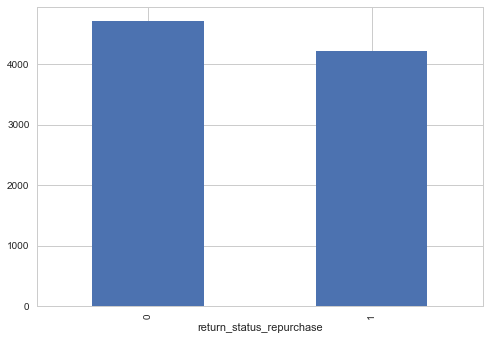

In [4]:
new_data.groupby("return_status_repurchase").size().plot(kind = "bar")

In [5]:
new_data.cid

0    10,000,242
0    10,000,242
0    10,000,242
0    10,001,026
0    10,002,227
0    10,003,650
0    10,003,650
0    10,004,320
0    10,004,401
0    10,004,401
0    10,004,401
0    10,004,853
0    10,005,603
0    10,005,695
0    10,005,902
0    10,005,902
0    10,006,201
0    10,006,201
0    10,006,215
0    10,006,312
0    10,006,744
0    10,006,978
0    10,008,087
0    10,008,566
0    10,008,566
0    10,008,962
0    10,010,019
0    10,010,146
0    10,011,448
0    10,011,701
        ...    
0    15,856,342
0    15,857,269
0    15,857,269
0    15,857,350
0    15,863,825
0    15,864,463
0    15,864,844
0    15,865,757
0    15,866,122
0    15,869,631
0    15,870,370
0    15,870,704
0    15,871,487
0    15,871,586
0    15,874,317
0    15,877,781
0    15,880,441
0    15,880,682
0    15,891,631
0    15,899,646
0    15,901,317
0    15,904,820
0    15,906,499
0    15,908,249
0    15,909,590
0    15,913,771
0    15,919,555
0    15,920,761
0    15,921,670
0    15,922,426
Name: cid, Length: 8923,

In [6]:
#### Save the processed data as an intermediate dataset
new_data.to_csv("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\01_New\\new_repurchase_product.csv",index=False,encoding='latin-1')

#### Dropping all columns where it has all missing values only ! 

In [7]:
### changing the dataset name to avoid confusion
main_data = new_data


#### Dropping all columns where it has all missing values only ! 
main_data = main_data.dropna(axis=1, how='all')
cust_data = cust_data.dropna(axis=1, how='all')
RFM_data = RFM_data.dropna(axis=1, how='all')

In [8]:
new_data.cid.shape

(8923,)

In [9]:
def quality_report(df):
    """
        Purpose : to create a report of column wise missing value and unique value counts and datatypes 
        Input : Dataframe
        Output : Dataframe with columns names, 
        types, no of observations, no of missing rows, No of unique values,
        % of data avaliable , % of data missing and 
        'Average','SD','MIN','25%','50%','75%','MAX'
        Usage : quality_report(df)

    """
    quality_df = pd.DataFrame()
    quality_df['Col_Name']=df.columns.sort_values()
    sorted_cols = df.columns.sort_values()
    quality_df['Col_Type'] = df[sorted_cols].dtypes.values
    quality_df['No_Of_Observations']=df[sorted_cols].apply(lambda x:len(x)).values
    quality_df['No_Of_Missing_Rows'] = df[sorted_cols].apply(lambda x:np.sum(pd.isnull(x))).values
    quality_df['No_Of_Uniques'] = df[sorted_cols].apply(lambda x:len(x.unique())).values
    quality_df['Data_Avaliable'] = quality_df['No_Of_Observations']-quality_df['No_Of_Missing_Rows']
    quality_df['AvailablePercentage']=np.round(quality_df['Data_Avaliable']/quality_df['No_Of_Observations'],2)
    quality_df['Miss_Pct']=np.round(1-quality_df['AvailablePercentage'],2)
    summary = df.describe().T.reset_index()
    summary.columns=['Col_Name','count','Average','SD','MIN','25%','50%','75%','MAX']
    summary.drop(['count'],axis=1,inplace=True)
    quality_df=pd.merge(quality_df,summary,left_on='Col_Name',right_on='Col_Name',how='outer')
    #quality_df.apply(lambda x:fillna(0, inplace=True))
    quality_df = quality_df.fillna(0)
    return quality_df



# Col_Name
# Col_Type
# No_Of_Observations
# No_Of_Missing_Rows
# No_Of_Uniques
# AvailablePercentage
# Col_Type_Def 
# Col_Keep
# Impute_method
# Levels_to_Keep


def quality_report_User_Edit(df):
    
    """
        Purpose : to create a report of column wise missing value and unique value counts and datatypes 
        Input : Dataframe
        Output : Dataframe with columns names, 
        types, no of observations, no of missing rows, No of unique values,
        % of data avaliable , % of data missing and 
        'Average','SD','MIN','25%','50%','75%','MAX'
        Usage : quality_report(df)

    """
    quality_df = pd.DataFrame()
    quality_df['Col_Name']=df.columns.sort_values()
    sorted_cols = df.columns.sort_values()
    quality_df['Col_Type'] = df[sorted_cols].dtypes.values
    quality_df['No_Of_Observations']=df[sorted_cols].apply(lambda x:len(x)).values
    quality_df['No_Of_Missing_Rows'] = df[sorted_cols].apply(lambda x:np.sum(pd.isnull(x))).values
    quality_df['No_Of_Uniques'] = df[sorted_cols].apply(lambda x:len(x.unique())).values
    quality_df['AvailablePercentage']=np.round(quality_df['Data_Avaliable']/quality_df['No_Of_Observations'],2)
    quality_df = quality_df.fillna(0)
    quality_df['Col_Type_Def'] = ""
    quality_df['Col_Keep'] = ""
    quality_df['Impute_method'] = ""
    quality_df['Levels_to_Keep'] = ""
    return quality_df

In [10]:
# quality_report(main_data).to_csv("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\01_New\\main.csv")
# quality_report(cust_data).to_csv("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\01_New\\cust.csv")
# quality_report(RFM_data).to_csv("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\01_New\\RFM.csv")

In [11]:
######### ---------------- Select only specific columns ----------- ############# 

def colums_to_select(main_data,filePath):
    """
    Purpose : Takes in a dataset and a CSV where column to select are defined and 
    selects only those columns.
    Inputs: Dataframe , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with desired columns selected
    Usage : type_conversion(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    select_vars = quality_report.loc[quality_report.Col_Keep =='Y','Col_Name']
    main_data = main_data[select_vars]
    
    return(main_data)

In [12]:
new_data.cid

0    10,000,242
0    10,000,242
0    10,000,242
0    10,001,026
0    10,002,227
0    10,003,650
0    10,003,650
0    10,004,320
0    10,004,401
0    10,004,401
0    10,004,401
0    10,004,853
0    10,005,603
0    10,005,695
0    10,005,902
0    10,005,902
0    10,006,201
0    10,006,201
0    10,006,215
0    10,006,312
0    10,006,744
0    10,006,978
0    10,008,087
0    10,008,566
0    10,008,566
0    10,008,962
0    10,010,019
0    10,010,146
0    10,011,448
0    10,011,701
        ...    
0    15,856,342
0    15,857,269
0    15,857,269
0    15,857,350
0    15,863,825
0    15,864,463
0    15,864,844
0    15,865,757
0    15,866,122
0    15,869,631
0    15,870,370
0    15,870,704
0    15,871,487
0    15,871,586
0    15,874,317
0    15,877,781
0    15,880,441
0    15,880,682
0    15,891,631
0    15,899,646
0    15,901,317
0    15,904,820
0    15,906,499
0    15,908,249
0    15,909,590
0    15,913,771
0    15,919,555
0    15,920,761
0    15,921,670
0    15,922,426
Name: cid, Length: 8923,

In [13]:
#############-----------------------TYPE CONVERSION OF THE COLUMNS-----------------------#############

def type_conversion(main_data,filePath):
   
    """
    Purpose : Takes in a dataset and a CSV where column types are defined and 
    converts each column in the dataset to the format specified in the CSV
    **working**: shoul Not  contains missing values in float or int type columns.
    Inputs: Dataframe to convert , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with desired datatype conversions
    Usage : type_conversion(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    quality_report=quality_report.loc[quality_report.Col_Keep =='Y',]
#     print(quality_report.shape)
    int_vars = quality_report.loc[quality_report.Col_Type_Def=='int64','Col_Name']
    float_vars = quality_report.loc[quality_report.Col_Type_Def=='float64','Col_Name']
    obj_vars = quality_report.loc[quality_report.Col_Type_Def=='object','Col_Name']
    
    for cols in int_vars:
        main_data[cols]=main_data[cols].astype('int64')
    for cols in float_vars:
        main_data[cols]=main_data[cols].astype('float64')
    for cols in obj_vars:
        main_data[cols]=main_data[cols].astype('object')
    return(main_data)


In [14]:
#### selecting specific columns 
filepath1 = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\main_Data_Dict.csv"
# quality_report = pd.read_csv(filepath1)
# select_vars = quality_report.loc[quality_report.Col_Keep =='Y','Col_Name']
# main_data = main_data[select_vars]
main_data = colums_to_select(main_data,filepath1)


main_data= main_data.reset_index()
main_data = main_data.drop(['index'],axis=1)
main_data.index


############# Some float values are missing############ 

### Dropping rows:72

indexes = list(main_data.loc[(main_data.amt_new==0)|(main_data.amt_old==0)|(main_data.prc_new==0)|(main_data.prc_old==0),].index)
main_data = main_data.drop(main_data.index[[indexes]])
main_data.shape
main_data.apply(lambda x: sum(pd.isnull(x)))

GMM_DESC                    138
PARENT_MDSE_DIVN_DESC       138
amt_new                       0
amt_old                       0
prc_chg_dollar                0
prc_chg_pct                   0
prc_chg_per_day               0
prc_new                       0
prc_old                       0
qty_new                       0
qty_old                       0
return_status_repurchase      0
returned_old_flag             0
time_to_new_purchase          0
dtype: int64

In [15]:
main_data = type_conversion(main_data,filepath1)

In [16]:
main_data.dtypes

GMM_DESC                     object
PARENT_MDSE_DIVN_DESC        object
amt_new                     float64
amt_old                     float64
prc_chg_dollar              float64
prc_chg_pct                 float64
prc_chg_per_day             float64
prc_new                     float64
prc_old                     float64
qty_new                       int64
qty_old                       int64
return_status_repurchase      int64
returned_old_flag            object
time_to_new_purchase          int64
dtype: object

### Target distribution

In [17]:
main_data.return_status_repurchase.value_counts()## 52% observations has RETURNED_YES and 48% has RETURNED_NO

0    4657
1    4194
Name: return_status_repurchase, dtype: int64

In [18]:
new_data.columns

Index(['cid', 'upc', 'oid_old', 'buy_dt_old', 'r_dt_old', 'prc_old', 'qty_old',
       'amt_old', 'r_qty_old', 'r_amt_old', 'oid_new', 'buy_dt_new',
       'r_dt_new', 'prc_new', 'qty_new', 'amt_new', 'r_qty_new', 'r_amt_new',
       'web_prod_id', 'PROD_DESC', 'PROD_TYP_DESC', 'BRND_NM', 'VND_NM',
       'GMM_DESC', 'PARENT_MDSE_DIVN_DESC', 'BUYER_DESC', 'MDSE_DEPT_DESC',
       'LBL_NM', 'prc_chg_dollar', 'prc_chg_pct', 'time_to_new_purchase',
       'prc_chg_per_day', 'return_duration_from_recent_buy', 'return_status',
       'returned_old_flag', 'return_status_repurchase'],
      dtype='object')

### Base model - hence dropping CID for now

In [19]:
######### ---------------- Creating dummies of categorical variables ----------- ############# 

def create_dummies_file(main_data,filePath):
    

    """
    Purpose : Takes in a dataset and a CSV where column def are present 
    identifies the cat variables and creates dummies for those variables
    Inputs: Dataframe , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with dummies created for all categorical variables
    Usage : create_dummies_file(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    quality_report = quality_report.loc[quality_report.Col_Keep =='Y',]
    dummy_vars = quality_report.loc[quality_report.Col_Type_Def =='object','Col_Name']
    main_data = pd.get_dummies(main_data,columns= dummy_vars)
    
    return(main_data)

In [20]:
encoding = LabelEncoder()
main_data['return_status_repurchase'] = encoding.fit_transform(main_data.return_status_repurchase)
main_data['return_status_repurchase'] = main_data['return_status_repurchase'].astype('int64')
main_data
# main_data = pd.get_dummies(main_data,columns=['GMM_DESC','PARENT_MDSE_DIVN_DESC','returned_old_flag'])

,GMM_DESC,PARENT_MDSE_DIVN_DESC,amt_new,amt_old,prc_chg_dollar,prc_chg_pct,prc_chg_per_day,prc_new,prc_old,qty_new,qty_old,return_status_repurchase,returned_old_flag,time_to_new_purchase
0,READY TO WEAR,SPECIAL SIZES,7.74,11.99,-4.25,-0.549096,-0.472222,7.74,11.99,1,1,1,N,8
1,MENS & KIDS,TOTAL CHILDRENS,23.99,45.00,-21.01,-0.875782,-0.656563,23.99,45.00,1,1,1,N,31
2,READY TO WEAR,SPECIAL SIZES,12.99,15.99,-3.00,-0.230947,-1.500000,12.99,15.99,1,1,1,N,1
3,READY TO WEAR,MILLENNIAL/DENIM,23.47,29.99,-6.52,-0.277801,-3.260000,23.47,29.99,1,1,1,N,1
4,READY TO WEAR,SPECIAL SIZES,17.99,35.99,-18.00,-1.000556,-0.620690,17.99,35.99,1,1,1,N,28
5,HOME,SOFT HOME,5.99,4.73,1.26,0.210351,0.011250,5.99,4.73,1,1,0,N,111
6,HOME,SOFT HOME,5.99,4.73,1.26,0.210351,0.011250,5.99,4.73,1,1,0,N,111
7,MENS & KIDS,TOTAL MENS,129.59,129.59,0.00,0.000000,0.000000,129.59,129.59,1,1,1,N,8
8,READY TO WEAR,COLLECTIONS RTW,29.99,29.99,0.00,0.000000,0.000000,29.99,29.99,1,1,1,N,6
9,READY TO WEAR,COLLECTIONS RTW,21.99,21.99,0.00,0.000000,0.000000,21.99,21.99,1,1,1,N,6


In [21]:
X = main_data.drop(['return_status_repurchase'],axis=1)
y = main_data['return_status_repurchase']

main_data = create_dummies_file(X,filepath1)

In [22]:
main_data.shape

(8851, 39)

Correlation plot of Main Data



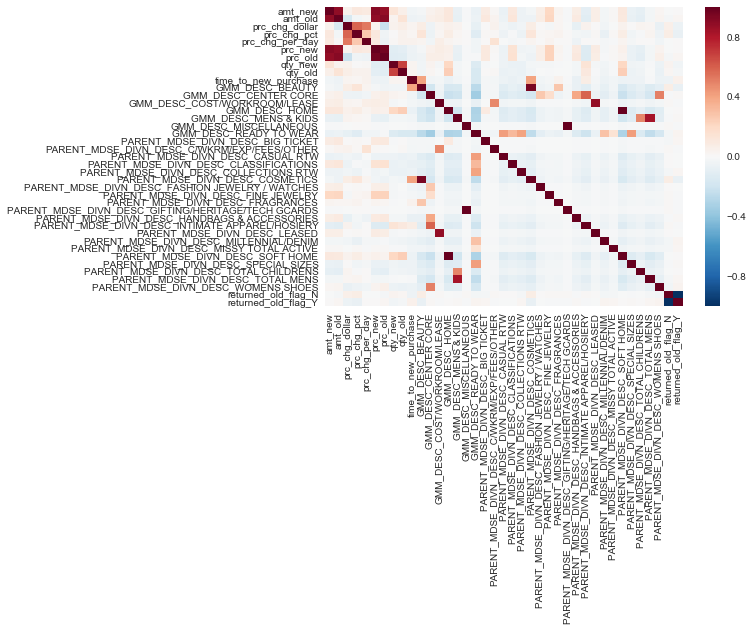

In [23]:
## Check the independence between the independent variables
sns.heatmap(main_data.corr())
# ,annot=True,linewidths=.5
print("Correlation plot of Main Data\n")
plt.show()

#### Seperating out the target variable and doing the test train split of data

In [24]:
#20% test data and 80% train set.
X_train,X_test,y_train,y_test = train_test_split(main_data,y,test_size=0.2,random_state= 0) 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(7080, 39)
(7080,)
(1771, 39)
(1771,)


#### This checks VIF values and then drops variables whose VIF is more than 5

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

In [25]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor    

# def calculate_vif_(X, thresh=5.0):
#     variables = range(X.shape[1])
#     dropped=True
#     while dropped:
#         dropped=False
#         vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

#         maxloc = vif.index(max(vif))
#         if max(vif) > thresh:
#             print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
#             del variables[maxloc]
#             dropped=True

#     print('Remaining variables:')
#     print(X.columns[variables])
#     return X[variables]

#### Feature Selection
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [26]:
# from sklearn import datasets
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# rfe = RFE(logreg, 18)
# rfe = rfe.fit(data_final[X], data_final[y] )
# print(rfe.support_)
# print(rfe.ranking_)


# cols=["previous", "euribor3m", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 
#       "month_aug", "month_dec", "month_jul", "month_nov", "month_oct", "month_sep", "day_of_week_fri", "day_of_week_wed", 
#       "poutcome_failure", "poutcome_nonexistent", "poutcome_success"] 
# X=data_final[cols]
# y=data_final['y']

Logistic Regression Assumptions
* Binary logistic regression requires the dependent variable to be binary.
* For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
* Only the meaningful variables should be included.
* The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
* The independent variables are linearly related to the log odds.
* Logistic regression requires quite large sample sizes.

In [27]:
### Implementing the Model 

# import statsmodels.api as sm
# logit_model=sm.Logit(y_train,X_train)
# result=logit_model.fit()
# print(result.summary())

## The p-values for most of the variables are smaller than 0.05, therefore, most of them are significant to the model.


In [28]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Confusion Matrix

In [29]:
print('Accuracy of Logistic Regression on Train data:',accuracy_score(y_train,model_logistic.predict(X_train)))
print('\n Confusion Matrix:')
confusion_matrix(y_train,model_logistic.predict(X_train))

Accuracy of Logistic Regression on Train data: 0.746186440678

 Confusion Matrix:


array([[2645, 1073],
       [ 724, 2638]])

In [30]:
print('Accuracy of Logistic Regression on Test data:',accuracy_score(y_test,model_logistic.predict(X_test)))
confusion_matrix(y_test,model_logistic.predict(X_test))

Accuracy of Logistic Regression on Test data: 0.732919254658


array([[647, 292],
       [181, 651]])

#### Cross Validation
Cross validation attempts to avoid overfitting while still producing a prediction for each observation dataset. 
We are using 10-fold Cross-Validation to train our Logistic Regression model.

In [31]:
# from sklearn import model_selection
# from sklearn.model_selection import cross_val_score
# kfold = model_selection.KFold(n_splits=10, random_state=7)
# modelCV = LogisticRegression()
# scoring = 'accuracy'
# results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
# print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

#### Compute precision, recall, F-measure and support
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [32]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))
print('Accuracy of Logistic Regression on Train data:',accuracy_score(y_train,model_logistic.predict(X_train)))
print('\n Confusion Matrix:')
confusion_matrix(y_train,model_logistic.predict(X_train))

print('Accuracy of Logistic Regression on Test data:',accuracy_score(y_test,model_logistic.predict(X_test)))
confusion_matrix(y_test,model_logistic.predict(X_test))

print(classification_report(y_test,model_logistic.predict(X_test)))

Accuracy of Logistic Regression on Train data: 0.746186440678

 Confusion Matrix:
Accuracy of Logistic Regression on Test data: 0.732919254658
             precision    recall  f1-score   support

          0       0.78      0.69      0.73       939
          1       0.69      0.78      0.73       832

avg / total       0.74      0.73      0.73      1771



In [33]:
model_logistic.score(X_train,y_train)

#Equation coefficient and Intercept
print('Coefficient: \n', model_logistic.coef_)
print('Intercept: \n', model_logistic.intercept_)

Coefficient: 
 [[  2.88059428e-03  -3.50589704e-03  -9.05160488e-03  -3.95204483e-01
   -4.15763264e-03  -7.93663967e-04   8.25794091e-03  -1.27234710e-01
   -9.49971025e-02  -1.53752537e-02  -7.23122082e-01  -8.93827613e-02
   -9.92107866e-01  -7.25282180e-01   1.22688422e-01  -3.99871283e-01
    5.60713133e-01  -6.48997404e-01  -1.75990374e+00  -2.13864938e-01
    8.33669007e-01   1.51267209e-01  -8.34868989e-01  -4.88825364e-01
   -3.55889933e-01   1.11746907e-01  -3.99871283e-01   5.80123326e-01
   -5.04443277e-01   7.67795873e-01   2.74781388e-01  -2.55006923e-01
   -7.62847760e-02  -2.30132608e-01   3.01726833e-01  -1.79038411e-01
    6.79652487e-01   1.93183077e+00  -3.39790004e+00]]
Intercept: 
 [-1.46606927]


#### ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).


0.735741403498


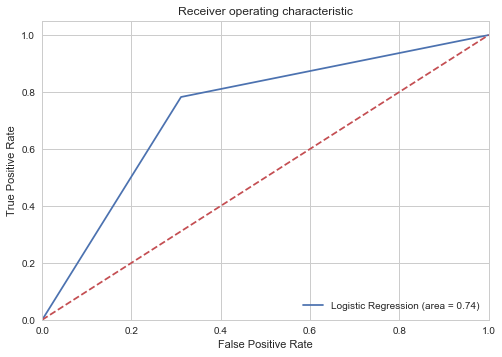

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test,model_logistic.predict(X_test))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test,model_logistic.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)

In [36]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [37]:
print('Accuracy of RANDOM_FOREST_MODEL on TRAIN_DATA:',accuracy_score(y_train,model_rf.predict(X_train)))
confusion_matrix(y_train,model_rf.predict(X_train))

Accuracy of RANDOM_FOREST_MODEL on TRAIN_DATA: 0.973728813559


array([[3657,   61],
       [ 125, 3237]])

In [38]:
print('Accuramodel_rfcy of RANDOM_FOREST_MODEL on TEST_DATA:',accuracy_score(y_test,model_rf.predict(X_test)))
confusion_matrix(y_test,model_rf.predict(X_test))

Accuramodel_rfcy of RANDOM_FOREST_MODEL on TEST_DATA: 0.727272727273


array([[709, 230],
       [253, 579]])

#### Variable Importance Plot

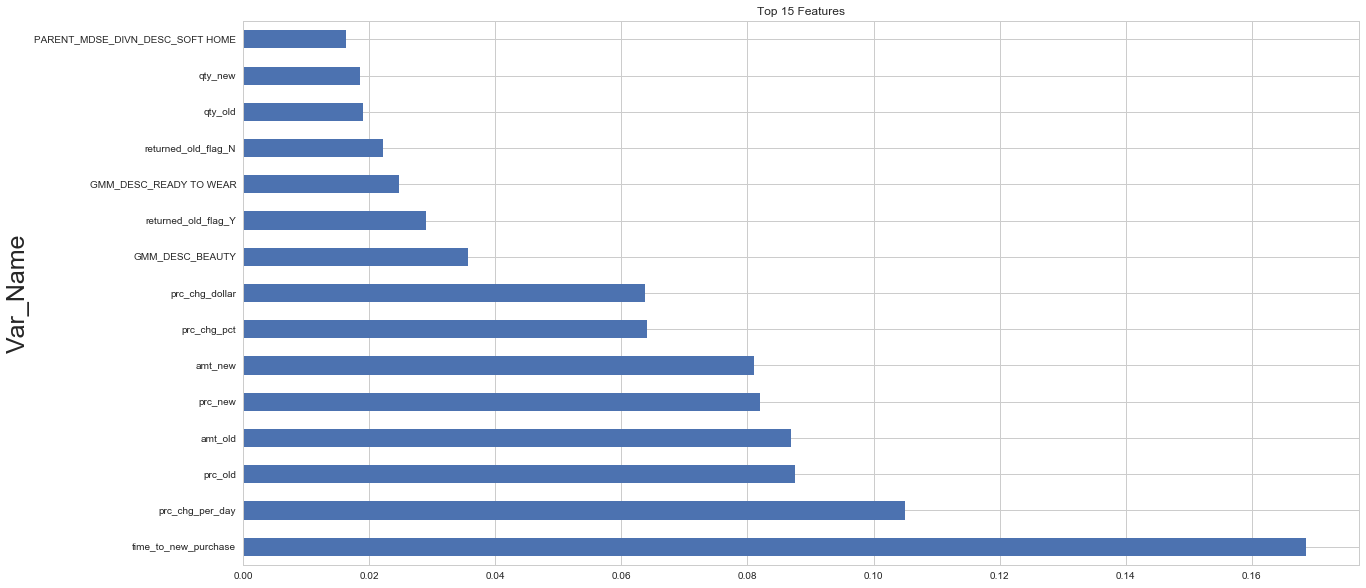

In [39]:
feat_imp = pd.Series(model_rf.feature_importances_, X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(20,10))
plt.ylabel('Var_Name',fontsize=25)
feat_imp[:15].plot(kind='barh', title='Top 15 Features')

### Data Distribution of final Predictors:

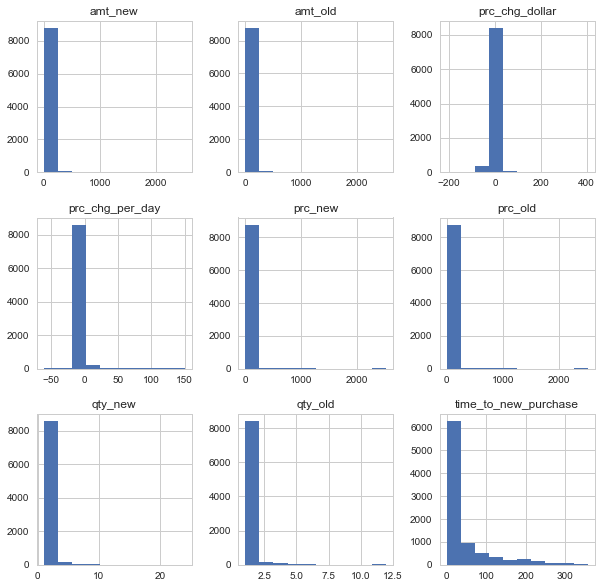

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,10
# plt.figure(figsize=(40,40))
main_data[['prc_old','qty_old','amt_old','prc_new','qty_new','amt_new','prc_chg_dollar',
           'time_to_new_purchase','prc_chg_per_day']].hist()
plt.show()

# The most basic model only includes crude level product attributes and sales data and variables derrived from sles data 

* We shall now include more datasets into our analysis
>* First keep the columns we are interested in 
>* Then we need to type convert the columns
>* Merge the sets using CID
>* Do some Exploratory analysis 
>* Run the model on the bigger dataset

In [41]:
new_data = new_data.reset_index()

new_data.head()


,index,cid,upc,oid_old,buy_dt_old,r_dt_old,prc_old,qty_old,amt_old,r_qty_old,...,MDSE_DEPT_DESC,LBL_NM,prc_chg_dollar,prc_chg_pct,time_to_new_purchase,prc_chg_per_day,return_duration_from_recent_buy,return_status,returned_old_flag,return_status_repurchase
0,0,"10,000,242","706,255,805,079",1289184165,2016-11-08 00:00:00,2016-12-01 00:00:00,11.99,1,11.99,1,...,CHARTER CLUB PLUS,CHARTER CLUB,-4.25,-0.549096,8,-0.472222,NaN,Returned Old,N,1
1,0,"10,000,242","785,498,037,447",1264484832,2016-10-19 00:00:00,2016-12-01 00:00:00,45,1,45,1,...,GIRLS 3-24 MONTHS,BONNIE JEAN,-21.01,-0.875782,31,-0.656563,NaN,Returned Old,N,1
2,0,"10,000,242","888,982,520,798",1298459769,2016-11-16 00:00:00,2016-12-01 00:00:00,15.99,1,15.99,1,...,KAREN SCOTT PLUS,KAREN SCOTT,-3,-0.230947,1,-1.5,NaN,Returned Old,N,1
3,0,"10,001,026","829,092,279,268",1298532543,2016-11-18 00:00:00,NaT,29.99,1,29.99,NaN,...,XOXO,XOXO,-6.52,-0.277801,1,-3.26,NaN,Returned New,N,1
4,0,"10,002,227","888,572,943,099",1202126220,2016-05-14 00:00:00,2016-06-16 00:00:00,35.99,1,35.99,1,...,LAUREN PLUS,LAUREN,-18,-1.00056,28,-0.62069,NaN,Returned Old,N,1


In [42]:
##### See a snippet of the data
cust_data.head()

,cid,LST_NM,MDDL_NM,FRST_NM,TTL_CD,TTL_DESC,DOB_DT,BIRTH_MNTH_CD,GNDR_CD,EMP_CD,...,VACNT_IND,VLD_EMAIL_ADDR_IND,AFLT_IND,SRC_DEL_IND,SRC_SYS_ID,ETL_CRT_TS,ETL_UPD_TS,ETL_BATCH_ID,ETL_PRG_NM,Prod
0,10005164,CONNELL,NaN,WILLIAM,1,1 - Mr,7/18/1953,7.0,M,15.0,...,N,Y,N,0,5,02-09-2017 5.49,1/23/2018 5:39,51354,CIM_IDM_MCOM_INDIV_MSTR_DMGRPH_Upd_40JB,NaN
1,10008087,JONES,NaN,GINA,0,0 - Ms,NaN,NaN,F,NaN,...,N,Y,N,0,5,02-09-2017 5.49,01-02-2018 8.28,48678,CIM_IDM_MCOM_INDIV_MSTR_DMGRPH_Upd_40JB,NaN
2,10008962,JACOVINO,NaN,ROSEANN,0,0 - Ms,3/25/1967,3.0,F,0.0,...,N,Y,N,0,5,02-09-2017 5.49,1/23/2018 5:39,51354,CIM_IDM_MCOM_INDIV_MSTR_DMGRPH_Upd_40JB,NaN
3,10011876,RUBIN,NaN,CAROL,I,I - Individual,12/28/1948,12.0,U,0.0,...,N,Y,N,0,5,02-09-2017 5.49,1/22/2018 5:04,51213,CIM_IDM_MCOM_INDIV_MSTR_DMGRPH_Upd_40JB,NaN
4,10016324,MATEO,NaN,CAROL,I,I - Individual,NaN,NaN,U,NaN,...,N,Y,N,1,5,02-09-2017 5.49,9/14/2017 5:38,34649,CIM_IDM_MCOM_INDIV_MSTR_DMGRPH_Upd_50JB,NaN


In [43]:
RFM_data.head()

,INDIV_ID,HHLD_ID,PREF_INDIV_IN_HHLD_IND,CUST_ADD_TS,KEPT_ACCT_ID,KEPT_ACCT_TYP_CD,KEPT_MASK_ACCT_ID,KEPT_SRC_CD,KEPT_SOURCE_CD_DESC,FRST_PURCH_DT,...,ETL_UPD_TS,ETL_BATCH_ID,ETL_PRG_NM,INDIV_ID_TYP_CD,MAX_STAR_RWD_SPND_LVL_CD,MAX_STAR_RWD_SPND_LVL_DESC,PREV_STAR_RWD_SPND_LVL_CD,PREV_STAR_RWD_SPND_LVL_DESC,CUR_OIS_CD,CUR_OIS_DESC
0,10003650,10480025,1,1999-10-16 00:00:00.000000,8.700000e+14,PRP,8.700000e+14,1,1 - FACS,11-05-2007,...,2018-01-30 11:38:27.000000,51798,IDM_Indiv_Aggr_140JB,K,2.0,2 - Elite,1.0,1 - Premier Elite,3.0,HIGHLY INVOLVED
1,10005603,10005604,1,2004-12-15 00:00:00.000000,8.700000e+14,AMX,8.700000e+14,1,1 - FACS,22-12-2007,...,2018-01-30 11:38:27.000000,51798,IDM_Indiv_Aggr_140JB,K,1.0,1 - Premier Elite,1.0,1 - Premier Elite,3.0,HIGHLY INVOLVED
2,10015917,70094127,1,1997-10-22 00:00:00.000000,8.700000e+14,AMX,8.700000e+14,1,1 - FACS,29-12-2009,...,2018-01-30 14:53:16.000000,52293,CIM_IDM_MCOM_INDIV_MSTR_Upd_30JB,K,1.0,1 - Premier Elite,1.0,1 - Premier Elite,3.0,HIGHLY INVOLVED
3,10024438,123939371,1,2008-04-14 00:00:00.000000,8.700000e+14,AMX,8.700000e+14,1,1 - FACS,28-02-2009,...,2018-01-30 17:14:02.498382,52300,CIM_IDM_MCOM_INDIV_MSTR_STR_LST_PURCH_DT_Upd_20JB,K,2.0,2 - Elite,1.0,1 - Premier Elite,3.0,HIGHLY INVOLVED
4,10026720,10026721,1,2014-11-22 00:00:00.000000,8.700000e+14,AMX,8.700000e+14,N,N - Macys.com from FedFill,09-12-2012,...,2018-01-26 19:00:06.000000,51798,CIM_IDM_MCOM_INDIV_MSTR_Upd_30JB,K,4.0,4 - Undefined,4.0,4 - Undefined,3.0,HIGHLY INVOLVED


In [44]:
cust_ret_data['INDIV_ID'] = cust_ret_data['INDIV_ID'].astype('object')
cust_ret_data.dtypes

INDIV_ID          object
TOT_BUY_COUNT      int64
TOT_BUY_QTY        int64
TOT_BUY_AMT      float64
TOT_RET_COUNT      int64
TOT_RET_QTY        int64
TOT_RET_AMT      float64
dtype: object

In [45]:
cust_ret_data.head()

,INDIV_ID,TOT_BUY_COUNT,TOT_BUY_QTY,TOT_BUY_AMT,TOT_RET_COUNT,TOT_RET_QTY,TOT_RET_AMT
0,10004853,32,32,1250.81,4,4,225.54
1,10006312,12,12,777.89,5,5,311.00
2,10015827,317,318,12966.88,246,247,10010.86
3,10023561,51,53,2508.40,18,18,998.11
4,10024524,15,15,329.48,2,2,61.00


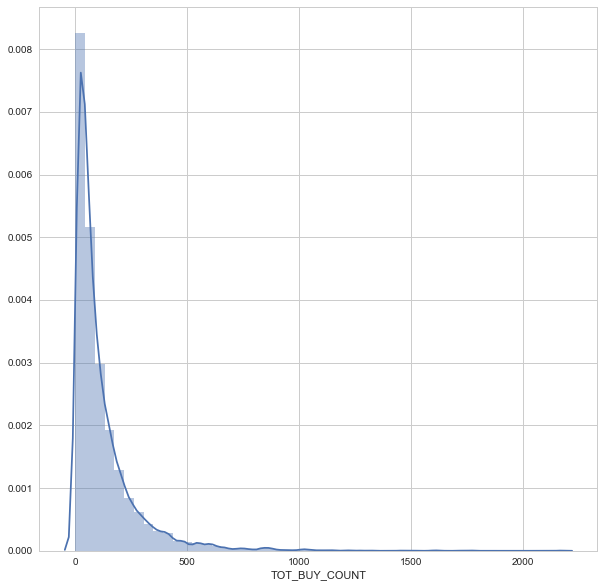

In [46]:
sns.distplot(cust_ret_data['TOT_BUY_COUNT'])

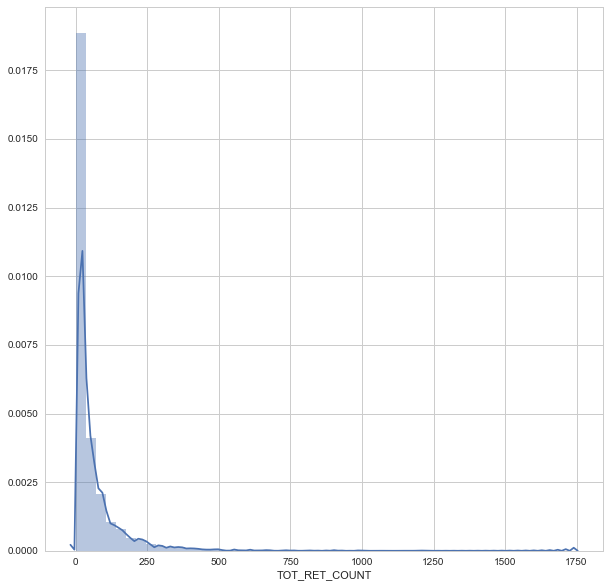

In [47]:
sns.distplot(cust_ret_data['TOT_RET_COUNT'])

In [48]:
new_data['cid'].apply(lambda x: int(x.replace(',', '')))

0       10000242
1       10000242
2       10000242
3       10001026
4       10002227
5       10003650
6       10003650
7       10004320
8       10004401
9       10004401
10      10004401
11      10004853
12      10005603
13      10005695
14      10005902
15      10005902
16      10006201
17      10006201
18      10006215
19      10006312
20      10006744
21      10006978
22      10008087
23      10008566
24      10008566
25      10008962
26      10010019
27      10010146
28      10011448
29      10011701
          ...   
8893    15856342
8894    15857269
8895    15857269
8896    15857350
8897    15863825
8898    15864463
8899    15864844
8900    15865757
8901    15866122
8902    15869631
8903    15870370
8904    15870704
8905    15871487
8906    15871586
8907    15874317
8908    15877781
8909    15880441
8910    15880682
8911    15891631
8912    15899646
8913    15901317
8914    15904820
8915    15906499
8916    15908249
8917    15909590
8918    15913771
8919    15919555
8920    159207

In [49]:
new_data['cid'] = new_data['cid'].apply(lambda x: int(x.replace(',', '')))
cust_ret_data2 = pd.merge(new_data, cust_ret_data,left_on='cid', right_on='INDIV_ID', how='left')
# sns.pairplot(cust_ret_data[['TOT_BUY_COUNT','TOT_BUY_QTY','TOT_BUY_AMT','TOT_RET_COUNT','TOT_RET_QTY','TOT_RET_AMT']])
# sns.pairplot(cust_ret_data[['TOT_BUY_COUNT','TOT_BUY_QTY','TOT_BUY_AMT','TOT_RET_COUNT','TOT_RET_QTY','TOT_RET_AMT']],hue="species")

In [50]:
cust_ret_data2

,index,cid,upc,oid_old,buy_dt_old,r_dt_old,prc_old,qty_old,amt_old,r_qty_old,...,return_status,returned_old_flag,return_status_repurchase,INDIV_ID,TOT_BUY_COUNT,TOT_BUY_QTY,TOT_BUY_AMT,TOT_RET_COUNT,TOT_RET_QTY,TOT_RET_AMT
0,0,10000242,"706,255,805,079",1289184165,2016-11-08 00:00:00,2016-12-01 00:00:00,11.99,1,11.99,1,...,Returned Old,N,1,10000242,266.0,269.0,6201.25,102.0,103.0,2956.88
1,0,10000242,"785,498,037,447",1264484832,2016-10-19 00:00:00,2016-12-01 00:00:00,45,1,45,1,...,Returned Old,N,1,10000242,266.0,269.0,6201.25,102.0,103.0,2956.88
2,0,10000242,"888,982,520,798",1298459769,2016-11-16 00:00:00,2016-12-01 00:00:00,15.99,1,15.99,1,...,Returned Old,N,1,10000242,266.0,269.0,6201.25,102.0,103.0,2956.88
3,0,10001026,"829,092,279,268",1298532543,2016-11-18 00:00:00,NaT,29.99,1,29.99,NaN,...,Returned New,N,1,10001026,162.0,164.0,5608.09,105.0,107.0,3816.24
4,0,10002227,"888,572,943,099",1202126220,2016-05-14 00:00:00,2016-06-16 00:00:00,35.99,1,35.99,1,...,Returned Old,N,1,10002227,101.0,123.0,4497.67,50.0,53.0,2500.94
5,0,10003650,"766,195,313,362",1204565952,2016-05-30 00:00:00,NaT,4.73,1,4.73,NaN,...,Both Kept,N,0,10003650,230.0,235.0,6141.01,24.0,25.0,1115.77
6,0,10003650,"766,195,344,984",1204565952,2016-05-30 00:00:00,NaT,4.73,1,4.73,NaN,...,Both Kept,N,0,10003650,230.0,235.0,6141.01,24.0,25.0,1115.77
7,0,10004320,"824,972,587,297",1244793249,2016-09-22 00:00:00,2016-10-12 00:00:00,129.59,1,129.59,1,...,Returned Old,N,1,10004320,23.0,24.0,1592.54,11.0,11.0,707.12
8,0,10004401,"190,049,556,412",1216546692,2016-07-27 00:00:00,2016-08-03 00:00:00,29.99,1,29.99,1,...,Both Returned,N,1,10004401,117.0,119.0,4555.77,84.0,85.0,3724.81
9,0,10004401,"190,049,556,597",1216546692,2016-07-27 00:00:00,2016-08-03 00:00:00,21.99,1,21.99,1,...,Both Returned,N,1,10004401,117.0,119.0,4555.77,84.0,85.0,3724.81


In [51]:

cust_ret_data3 = cust_ret_data2[['TOT_BUY_COUNT','TOT_BUY_QTY','TOT_BUY_AMT','TOT_RET_COUNT','TOT_RET_QTY','TOT_RET_AMT','return_status','return_status_repurchase']].dropna()


In [52]:
cust_ret_data3['Diff_Count'] = cust_ret_data3.TOT_BUY_COUNT - cust_ret_data3.TOT_RET_COUNT
cust_ret_data3['Diff_Qty']= cust_ret_data3.TOT_BUY_QTY - cust_ret_data3.TOT_RET_QTY
cust_ret_data3['Diff_Amt'] =  cust_ret_data3.TOT_BUY_AMT - cust_ret_data3.TOT_RET_AMT

In [53]:
cust_ret_data3

,TOT_BUY_COUNT,TOT_BUY_QTY,TOT_BUY_AMT,TOT_RET_COUNT,TOT_RET_QTY,TOT_RET_AMT,return_status,return_status_repurchase,Diff_Count,Diff_Qty,Diff_Amt
0,266.0,269.0,6201.25,102.0,103.0,2956.88,Returned Old,1,164.0,166.0,3244.37
1,266.0,269.0,6201.25,102.0,103.0,2956.88,Returned Old,1,164.0,166.0,3244.37
2,266.0,269.0,6201.25,102.0,103.0,2956.88,Returned Old,1,164.0,166.0,3244.37
3,162.0,164.0,5608.09,105.0,107.0,3816.24,Returned New,1,57.0,57.0,1791.85
4,101.0,123.0,4497.67,50.0,53.0,2500.94,Returned Old,1,51.0,70.0,1996.73
5,230.0,235.0,6141.01,24.0,25.0,1115.77,Both Kept,0,206.0,210.0,5025.24
6,230.0,235.0,6141.01,24.0,25.0,1115.77,Both Kept,0,206.0,210.0,5025.24
7,23.0,24.0,1592.54,11.0,11.0,707.12,Returned Old,1,12.0,13.0,885.42
8,117.0,119.0,4555.77,84.0,85.0,3724.81,Both Returned,1,33.0,34.0,830.96
9,117.0,119.0,4555.77,84.0,85.0,3724.81,Both Returned,1,33.0,34.0,830.96


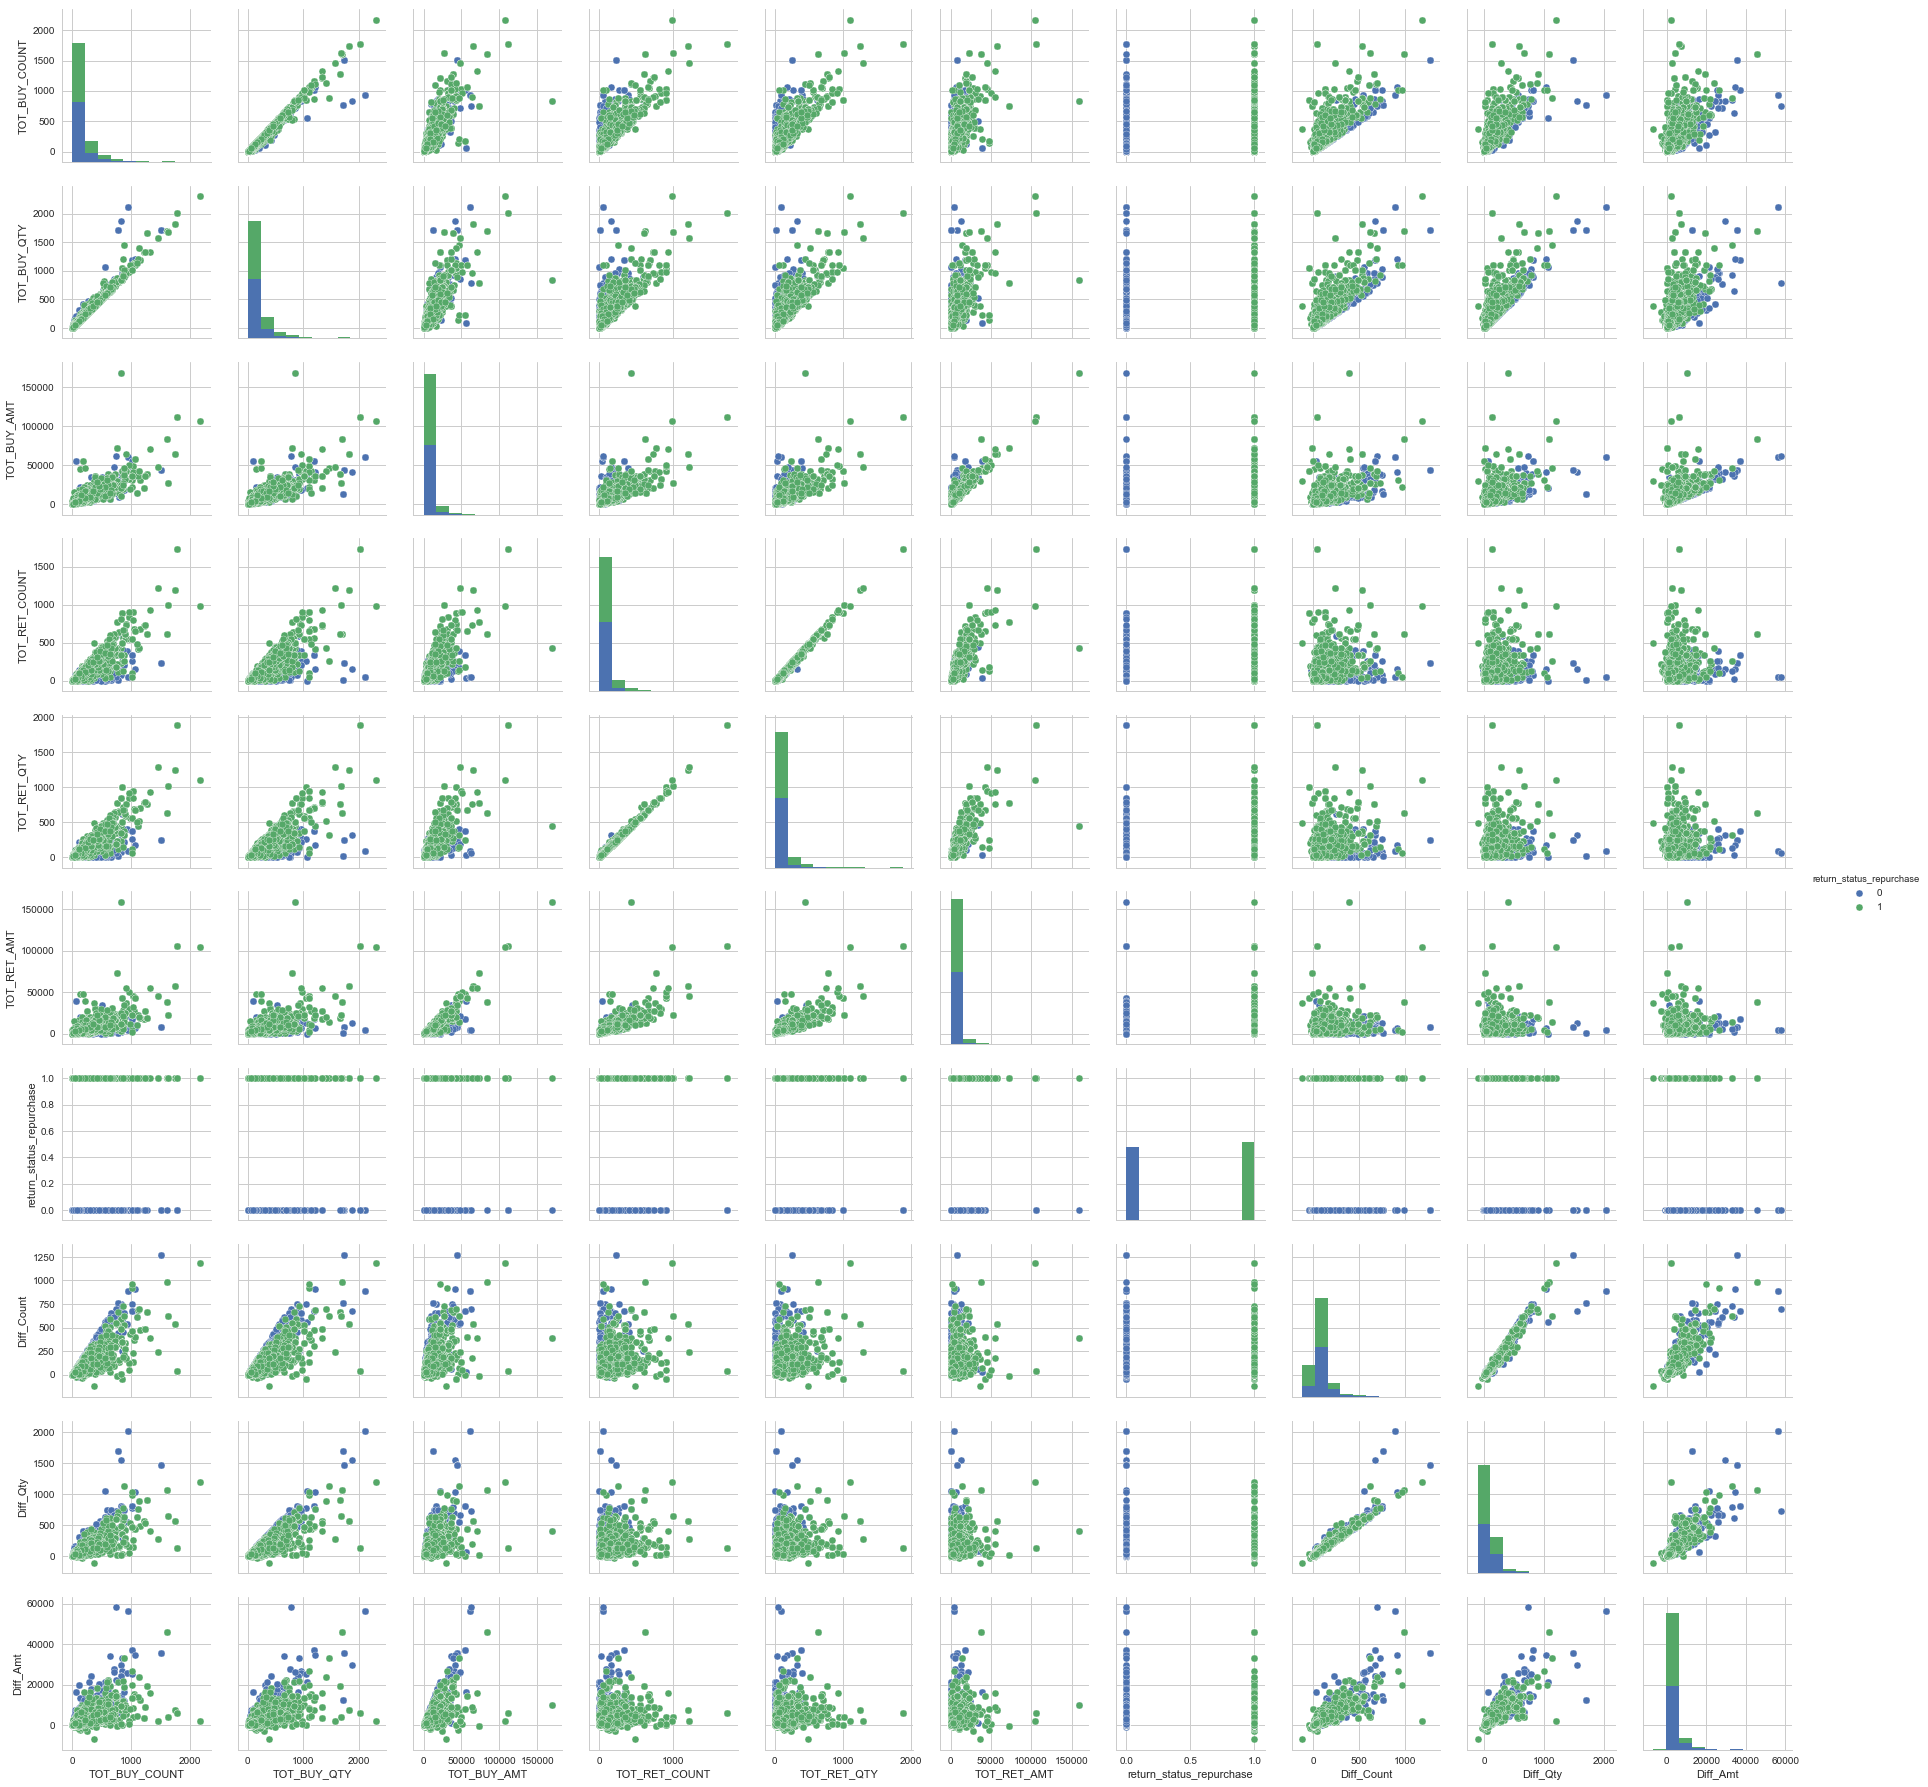

In [54]:
sns.pairplot(cust_ret_data3,hue = 'return_status_repurchase')

In [55]:
new_data.columns

Index(['index', 'cid', 'upc', 'oid_old', 'buy_dt_old', 'r_dt_old', 'prc_old',
       'qty_old', 'amt_old', 'r_qty_old', 'r_amt_old', 'oid_new', 'buy_dt_new',
       'r_dt_new', 'prc_new', 'qty_new', 'amt_new', 'r_qty_new', 'r_amt_new',
       'web_prod_id', 'PROD_DESC', 'PROD_TYP_DESC', 'BRND_NM', 'VND_NM',
       'GMM_DESC', 'PARENT_MDSE_DIVN_DESC', 'BUYER_DESC', 'MDSE_DEPT_DESC',
       'LBL_NM', 'prc_chg_dollar', 'prc_chg_pct', 'time_to_new_purchase',
       'prc_chg_per_day', 'return_duration_from_recent_buy', 'return_status',
       'returned_old_flag', 'return_status_repurchase'],
      dtype='object')

In [131]:
filepath_cust = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\cust_Data_Dict.csv"
filepath_RFM = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\RFM_Data_Dict.csv"
filepath_main = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\main2_Data_Dict.csv"

In [132]:
new_data = colums_to_select(new_data,filepath_main)
cust_data = colums_to_select(cust_data,filepath_cust)
RFM_data = colums_to_select(RFM_data,filepath_RFM)

In [133]:
new_data.shape

(8923, 15)

In [134]:
new_data = type_conversion(new_data,filepath_main)
cust_data = type_conversion(cust_data,filepath_cust)
RFM_data = type_conversion(RFM_data,filepath_RFM)

## Merge the datasets

>* new_data 
>* cust_data
>* RF_data
>* cust_ret_data

In [105]:
### Check if the CIDs are in the correct format 

new_data['cid'].iloc[0]

10000242

In [106]:
cust_data['cid'].iloc[0]

10005164

In [62]:
RFM_data['INDIV_ID'].iloc[0]

10003650

In [63]:
cust_ret_data['INDIV_ID'].iloc[0]

10004853

In [135]:
cust_ret_data['Diff_Count'] = cust_ret_data.TOT_BUY_COUNT - cust_ret_data.TOT_RET_COUNT
cust_ret_data['Diff_Qty']= cust_ret_data.TOT_BUY_QTY - cust_ret_data.TOT_RET_QTY
cust_ret_data['Diff_Amt'] =  cust_ret_data.TOT_BUY_AMT - cust_ret_data.TOT_RET_AMT
cust_ret_data['per_Diff_Count'] = cust_ret_data.TOT_RET_COUNT/cust_ret_data.TOT_BUY_COUNT
cust_ret_data['per_Diff_Qty']= cust_ret_data.TOT_RET_QTY/cust_ret_data.TOT_BUY_QTY
cust_ret_data['per_Diff_Amt'] =  cust_ret_data.TOT_RET_AMT/cust_ret_data.TOT_BUY_AMT

In [136]:
cust_ret_data.shape

(7002, 13)

In [137]:
cust_ret_data[cust_ret_data.TOT_BUY_AMT < cust_ret_data.TOT_RET_AMT]

,INDIV_ID,TOT_BUY_COUNT,TOT_BUY_QTY,TOT_BUY_AMT,TOT_RET_COUNT,TOT_RET_QTY,TOT_RET_AMT,Diff_Count,Diff_Qty,Diff_Amt,per_Diff_Count,per_Diff_Qty,per_Diff_Amt
375,11526736,21,22,393.23,12,13,632.68,9,9,-239.45,0.571429,0.590909,1.608931
547,12492573,186,251,14282.47,199,257,14629.23,-13,-6,-346.76,1.069892,1.023904,1.024279
726,14022075,70,70,2559.99,95,95,3369.49,-25,-25,-809.50,1.357143,1.357143,1.316212
859,15079263,119,123,3832.19,109,109,3869.42,10,14,-37.23,0.915966,0.886179,1.009715
1277,11599225,367,378,29454.66,491,491,36399.40,-124,-113,-6944.74,1.337875,1.298942,1.235777
1342,11986262,159,165,9495.44,164,167,9539.50,-5,-2,-44.06,1.031447,1.012121,1.004640
1485,13044317,115,127,3625.66,93,99,3638.89,22,28,-13.23,0.808696,0.779528,1.003649
1528,13401899,113,202,6699.59,137,217,7501.26,-24,-15,-801.67,1.212389,1.074257,1.119660
1585,14030829,10,10,2750.96,9,9,2858.96,1,1,-108.00,0.900000,0.900000,1.039259
1608,14189799,15,15,352.74,15,15,354.95,0,0,-2.21,1.000000,1.000000,1.006265


In [138]:
tot_data = pd.merge(new_data, cust_ret_data,left_on='cid', right_on='INDIV_ID', how='left')

In [139]:
tot_data = pd.merge(tot_data, cust_data,left_on='cid', right_on='cid', how='left')

In [140]:
tot_data = pd.merge(tot_data, RFM_data,left_on='cid', right_on='INDIV_ID', how='left')

In [141]:
tot_data.shape

(8923, 70)

In [142]:
from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [148]:
#pd.DataFrame(tot_data.columns).to_csv('variables.csv')

In [144]:
# tot_data.drop(['cid','INDIV_ID_x','TOT_RET_COUNT','TOT_RET_QTY', 'TOT_RET_AMT', 'Diff_Count', 'Diff_Qty', 'Diff_Amt','DOB_DT', 'EXT_ONLN_FRST_PURCH_DT','FRST_PURCH_DT', 'FRST_REG_DT', 'INDIV_ID_y','INDIV_LST_PURCH_DT','LST_PURCH_DT','EMP_CD','ONLN_FRST_PURCH_DT', 'PRIZM_DESC','ONLN_LST_PURCH_DT','STR_FRST_PURCH_DT', 'STR_LST_PURCH_DT'],axis=1,inplace=True)
tot_data.drop(['PRIZM_DESC'],axis = 1 , inplace = True)

In [119]:
# tot_data.dropna()
tot_data.select_dtypes(include=['object']).columns

Index(['GMM_DESC', 'PARENT_MDSE_DIVN_DESC', 'cid', 'returned_old_flag',
       'INDIV_ID_x', 'AFLT_IND', 'DLVR_SEQ_FILE_DLVR_IND_CD_DESC',
       'DLVR_SEQ_FILE_DLVR_TYP_CD_DESC', 'DOB_DT', 'EMP_CD', 'EMP_IND',
       'FED_EMP_IND', 'GNDR_CD', 'MBL_PHN_IND', 'SEASNL_IND',
       'SEC_NBR_NOT_FND_IND', 'SMS_IND', 'SUPPR_DMA_MAIL_IND', 'VACNT_IND',
       'VLD_EMAIL_ADDR_IND', 'CURR_DH_MY_LIFE_DESC', 'CURR_DH_SHOP_HABIT_DESC',
       'CUR_OIS_DESC', 'EXT_ONLN_FRST_PURCH_DT', 'FRST_PURCH_DT',
       'FRST_REG_DT', 'F_SCR_NBR', 'INDIV_ID_y', 'INDIV_LST_PURCH_DT',
       'KEPT_ACCT_TYP_CD', 'KEPT_SOURCE_CD_DESC', 'LST_PURCH_DT',
       'MAX_STAR_RWD_SPND_LVL_DESC', 'MAX_VIP_CD_DESC', 'M_SCR_NBR',
       'ONLN_FRST_PURCH_DT', 'ONLN_LST_PURCH_DT', 'RFM_SEG_IND', 'R_SCR_NBR',
       'STR_FRST_PURCH_DT', 'STR_LST_PURCH_DT'],
      dtype='object')

In [149]:
total=tot_data.isnull().sum().sort_values(ascending=False)
percent=(tot_data.isnull().sum()/tot_data.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)
                       


,Total,Percent
FRST_REG_DT,1630,0.182674
EMP_CD,1629,0.182562
DOB_DT,1601,0.179424
TOT_RET_AMT,870,0.097501
TOT_RET_QTY,870,0.097501
TOT_RET_COUNT,870,0.097501
Diff_Count,870,0.097501
TOT_BUY_AMT,870,0.097501
Diff_Qty,870,0.097501
TOT_BUY_QTY,870,0.097501


In [150]:
tot_data1=tot_data.drop(['INDIV_ID_x','prc_chg_pct','EXT_ONLN_FRST_PURCH_DT','FRST_REG_DT','EMP_CD','DOB_DT','per_Diff_Amt','per_Diff_Qty','per_Diff_Count','INDIV_LST_PURCH_DT','TOT_BUY_AMT','TOT_BUY_QTY','TOT_RET_COUNT','TOT_RET_AMT','TOT_RET_QTY'],axis=1,inplace=True)


In [151]:
tot_data2=tot_data.drop(['INDIV_LST_PURCH_DT','TOT_BUY_AMT','TOT_BUY_QTY','TOT_RET_COUNT','TOT_RET_AMT','TOT_RET_QTY'],axis=1,inplace=True)

ValueError: labels ['INDIV_LST_PURCH_DT' 'TOT_BUY_AMT' 'TOT_BUY_QTY' 'TOT_RET_COUNT'
 'TOT_RET_AMT' 'TOT_RET_QTY'] not contained in axis

In [152]:
tot_data.dropna(subset=['AFLT_IND','GMM_DESC','MAX_STAR_RWD_SPND_LVL_DESC','PARENT_MDSE_DIVN_DESC','CUR_OIS_DESC','Diff_Qty','Diff_Count','Diff_Amt','LST_PURCH_DT','FRST_PURCH_DT','ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT','STR_FRST_PURCH_DT','STR_LST_PURCH_DT'],inplace=True,how='any')

In [158]:
pd.DataFrame(tot_data.columns).to_csv('variables_ash.csv')

In [153]:
### Change_dates ###
dates_consider=['ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT','STR_FRST_PURCH_DT','STR_LST_PURCH_DT']
for col in dates_consider:
    tot_data[col]=pd.to_datetime(tot_data[col])



In [154]:
tot_data['Active_Online_status']=(tot_data.ONLN_LST_PURCH_DT-tot_data.ONLN_FRST_PURCH_DT).dt.days
tot_data['Active_STR_Status']=(tot_data.STR_LST_PURCH_DT-tot_data.STR_FRST_PURCH_DT).dt.days

In [155]:
tot_data.drop(['FRST_PURCH_DT','LST_PURCH_DT','prc_chg_per_day','prc_new','qty_new'],axis=1,inplace=True)

In [127]:
tot_data.to_csv('tot_dataa.csv')

In [160]:
tot_data.Diff_Count

0       164.0
1       164.0
2       164.0
3        57.0
4        51.0
5       206.0
6       206.0
7        12.0
8        33.0
9        33.0
10       33.0
11       28.0
12       19.0
13       17.0
16       18.0
17       18.0
18       35.0
19        7.0
20       15.0
21       35.0
22       31.0
23      214.0
24      214.0
26       70.0
28       25.0
29       74.0
30       65.0
31      111.0
32      111.0
33      111.0
        ...  
8889    488.0
8890    488.0
8891     48.0
8892     44.0
8893     24.0
8894     20.0
8895     20.0
8897    135.0
8898    109.0
8899     15.0
8900     39.0
8901     66.0
8902      0.0
8904     92.0
8905     38.0
8906    152.0
8907     51.0
8908    297.0
8909     26.0
8910    377.0
8911     40.0
8912    185.0
8913      8.0
8914     24.0
8916     36.0
8917     38.0
8918      8.0
8919     26.0
8920     29.0
8921    115.0
Name: Diff_Count, Length: 7454, dtype: float64

In [161]:
tot_data.drop(['Diff_Count'],inplace=True,axis=1)

In [159]:
tot_data.drop(['Diff_Qty','Diff_Count','cid','returned_old_flag','MAX_STAR_RWD_SPND_LVL_DESC','INDIV_ID_y','STR_FRST_PURCH_DT','STR_LST_PURCH_DT','ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT'],inplace=True,axis=1)

ValueError: labels ['Diff_Qty' 'cid' 'returned_old_flag' 'MAX_STAR_RWD_SPND_LVL_DESC'
 'INDIV_ID_y' 'STR_FRST_PURCH_DT' 'STR_LST_PURCH_DT' 'ONLN_FRST_PURCH_DT'
 'ONLN_LST_PURCH_DT'] not contained in axis

In [162]:
cat_var=['GMM_DESC', 'PARENT_MDSE_DIVN_DESC', 'AFLT_IND',
       'DLVR_SEQ_FILE_DLVR_IND_CD_DESC', 'DLVR_SEQ_FILE_DLVR_TYP_CD_DESC',
       'EMP_IND', 'FED_EMP_IND', 'GNDR_CD', 'MBL_PHN_IND', 'SEASNL_IND',
       'SEC_NBR_NOT_FND_IND', 'SMS_IND', 'SUPPR_DMA_MAIL_IND', 'VACNT_IND',
       'VLD_EMAIL_ADDR_IND', 'CURR_DH_MY_LIFE_DESC', 'CURR_DH_SHOP_HABIT_DESC',
       'CUR_OIS_DESC', 'F_SCR_NBR', 'KEPT_ACCT_TYP_CD', 'KEPT_SOURCE_CD_DESC',
       'MAX_VIP_CD_DESC', 'M_SCR_NBR', 'RFM_SEG_IND', 'R_SCR_NBR']

In [ ]:
# tot_data.Diff_Amt
# tot_data.Diff_Count
# tot_data.Diff_Qty

In [163]:
tot_data=pd.get_dummies(tot_data,columns=cat_var)

In [164]:
tot_data['return_status_repurchase']=tot_data.return_status_repurchase.astype('object')

In [165]:
tot_data['return_status_repurchase'].dtypes

dtype('O')

In [166]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
tot_data['return_status_repurchase'] = le.fit_transform(tot_data['return_status_repurchase'])
  

In [167]:
tot_data.shape

(7454, 155)

In [168]:
X = tot_data.drop('return_status_repurchase',axis=1)
y = tot_data['return_status_repurchase']

#tot_data = create_dummies_file(X,filepath1)



In [169]:
tot_data.to_csv("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\01_New\\tot.csv")

In [170]:
#20% test data and 80% train set.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
#X_train.shape
#X_train,X_test,y_train,y_test = train_test_split(tot_data,y,test_size=0.2,random_state= 0) 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(5963, 154)
(5963,)
(1491, 154)
(1491,)


In [172]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [173]:
print('Accuracy of Logistic Regression on Train data:',accuracy_score(y_train,model_logistic.predict(X_train)))
print('\n Confusion Matrix:')
confusion_matrix(y_train,model_logistic.predict(X_train))

print('Accuracy of Logistic Regression on Test data:',accuracy_score(y_test,model_logistic.predict(X_test)))
confusion_matrix(y_test,model_logistic.predict(X_test))

print(classification_report(y_test,model_logistic.predict(X_test)))

Accuracy of Logistic Regression on Train data: 0.759013919168

 Confusion Matrix:
Accuracy of Logistic Regression on Test data: 0.739101274313
             precision    recall  f1-score   support

          0       0.78      0.69      0.73       761
          1       0.71      0.79      0.75       730

avg / total       0.74      0.74      0.74      1491



In [ ]:
cols=['Diff_Count', 'Diff_Qty','Diff_Amt']
corr_matrix = tot_data[cols].corr()
heatmap = sns.heatmap(corr_matrix,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 10},yticklabels=cols,xticklabels=cols,cmap='Dark2')

In [ ]:
### Randomforest #####33

In [174]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=4, n_estimators=20, random_state=0)


rf.fit(X_train,y_train)
train_predicions = rf.predict(X_train)
test_predicions = rf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,test_predicions))
print(classification_report(y_test,test_predicions))

[[476 285]
 [122 608]]
             precision    recall  f1-score   support

          0       0.80      0.63      0.70       761
          1       0.68      0.83      0.75       730

avg / total       0.74      0.73      0.72      1491



In [175]:
## Error matrix ###
from sklearn.metrics import accuracy_score
print(accuracy_score(rf.predict(X_train),y_train))   
print(accuracy_score(rf.predict(X_test),y_test))    


0.743250041925
0.727028839705


In [179]:
X_train.shape

(5963, 154)

In [180]:
X_test.shape

(1491, 154)